In [11]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, MixedHMC, HMC
from jax import random
import jax.numpy as jnp
import plotly.express as px
import plotly.io as pio
import numpy as np
from scipy import stats
import pyvinecopulib as pv
from pyvinecopulib import Bicop
import graphviz
import funsor

In [12]:
pio.renderers.default = "svg"

Graph showing associations between variables 1, 2, and 3:

3 --- 1 --- 2

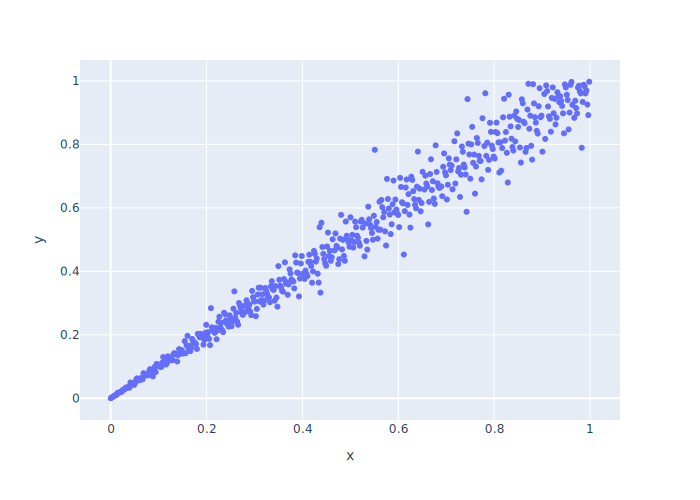

In [85]:
# Specify pair-copulas
# https://notebook.community/vinecopulib/pyvinecopulib/examples/bivariate_copulas
bicop_1_2 = pv.Bicop(
    family=pv.BicopFamily.clayton, 
    rotation=0,
    parameters=[20]
)
bicop_1_2_sims = bicop_1_2.simulate(
    n=500,
    qrng=True
)
fig = px.scatter(
    x=bicop_1_2_sims[:, 0],
    y=bicop_1_2_sims[:, 1]
)
fig.show()

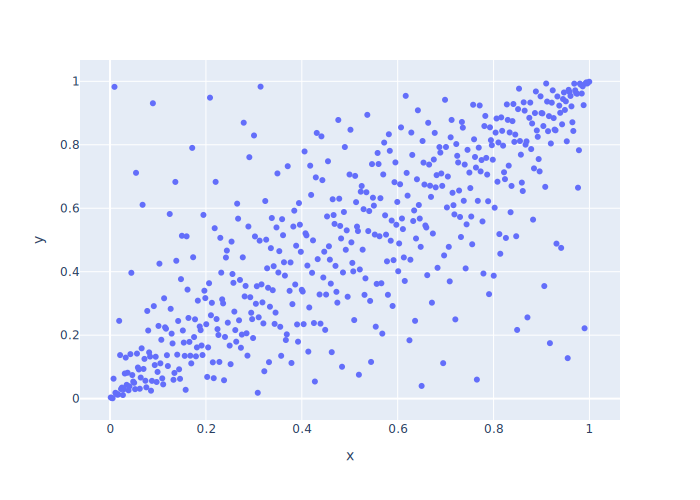

In [86]:
bicop_1_3 = pv.Bicop(
    family=pv.BicopFamily.student, 
    rotation=0,
    parameters=[0.78, 2]
)
bicop_1_3_sims = bicop_1_3.simulate(
    n=500,
    qrng=True
)
fig = px.scatter(
    x=bicop_1_3_sims[:, 0],
    y=bicop_1_3_sims[:, 1]
)
fig.show()

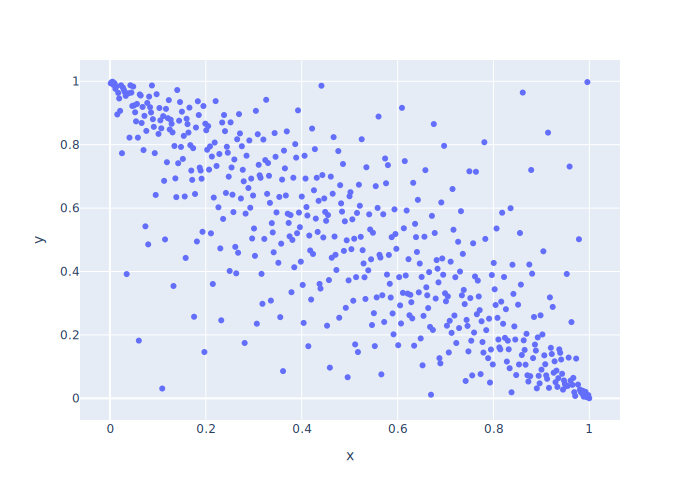

In [87]:
bicop_2_3_conditioned_on_1 = pv.Bicop(
    family=pv.BicopFamily.student, 
    rotation=0,
    parameters=[-0.8, 2]
)
bicop_2_3_conditioned_on_1_sims = bicop_2_3_conditioned_on_1.simulate(
    n=500,
    qrng=True
)
fig = px.scatter(
    x=bicop_2_3_conditioned_on_1_sims[:, 0],
    y=bicop_2_3_conditioned_on_1_sims[:, 1]
)
fig.show()

# R-vine Modelling and Pair-Copula Construction

In [88]:
# https://vinecopulib.github.io/pyvinecopulib/_generate/pyvinecopulib.Vinecop.__init__.html
pair_copulas = [
    # 0th tree
    [bicop_1_2, bicop_1_3], 
    # 1st tree
    [bicop_2_3_conditioned_on_1]
]

# Specify R-vine matrix
mat = np.array([
    [1, 2, 2], 
    [2, 1, 0], 
    [3, 0, 0]
])

r_vine_structure = pv.RVineStructure(
    mat=mat,
    check=True
)

# Set-up a vine copula
cop = pv.Vinecop(
    structure=r_vine_structure,
    pair_copulas=pair_copulas,
    var_types=["d", "c", "c"]
)

print(cop)

<pyvinecopulib.Vinecop>
** Tree: 0
3,1 <-> Clayton, parameters = 20
1,2 <-> Student, parameters = 0.78
   2
** Tree: 1
3,2 | 1 <-> Student, parameters = -0.8
   2



In [89]:
cop_sims = cop.simulate(
    n=500,
    qrng=True
)
print(cop_sims.shape)

(500, 3)


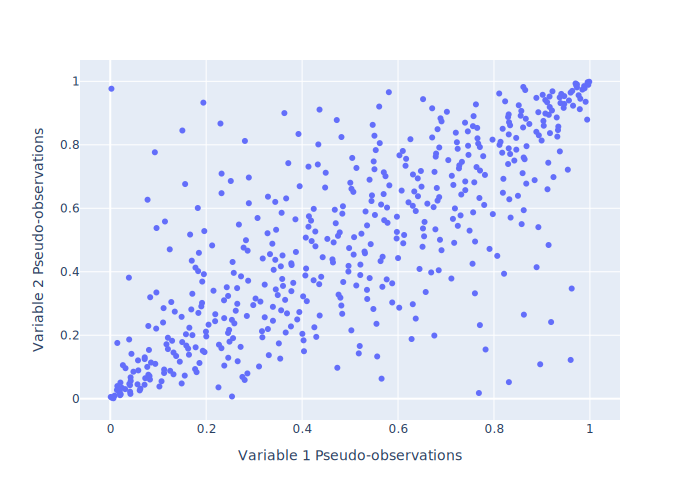

In [90]:
fig = px.scatter(
    x=cop_sims[:, 0],
    y=cop_sims[:, 1],
    labels={
        "x": "Variable 1 Pseudo-observations",
        "y": "Variable 2 Pseudo-observations"
    }
)
fig.show()

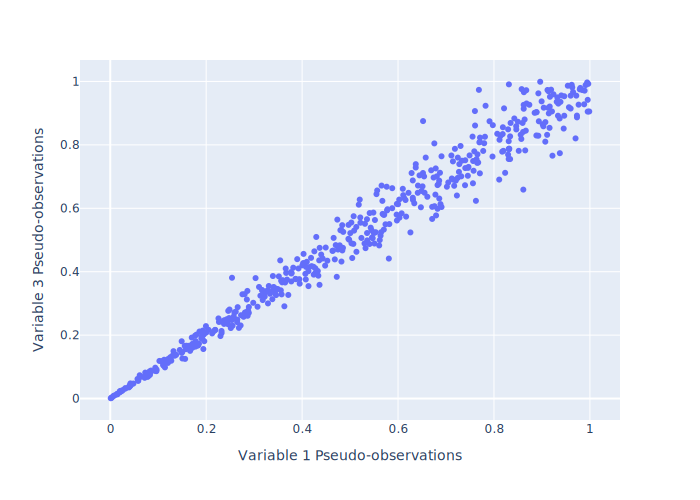

In [91]:
fig = px.scatter(
    x=cop_sims[:, 0],
    y=cop_sims[:, 2],
    labels={
        "x": "Variable 1 Pseudo-observations",
        "y": "Variable 3 Pseudo-observations"
    }
)
fig.show(renderer="svg")

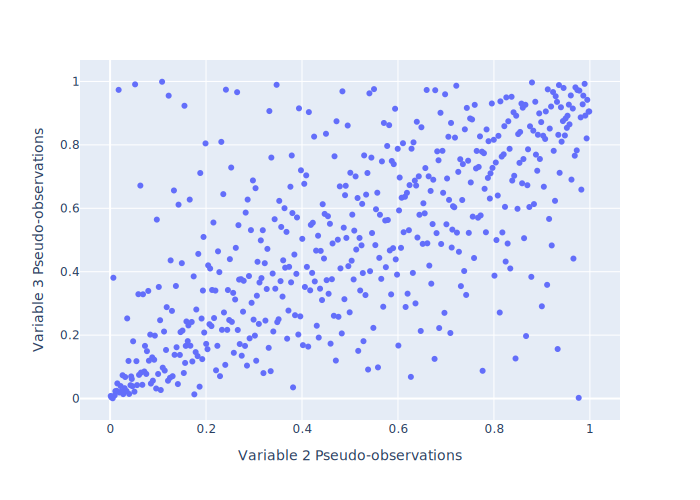

In [92]:
fig = px.scatter(
    x=cop_sims[:, 1],
    y=cop_sims[:, 2],
    labels={
        "x": "Variable 2 Pseudo-observations",
        "y": "Variable 3 Pseudo-observations"
    }
)
fig.show()

# Transformation of Uniform Marginals

In [158]:
def get_ordered_array(
    x,
    sort_helper
):
    indices_to_sort = np.argsort(
        a=sort_helper,
        axis=0
    )

    return x[indices_to_sort]

In [159]:
# Samples from our marginal distributions.
var_0_unordered_samples = stats.binom.rvs(
    n=365,
    p=0.8,
    size=500
)

var_1_unordered_samples = stats.lognorm.rvs(
    s=1,
    size=500
)

var_2_unordered_samples = stats.beta.rvs(
    a=1.5,
    b=6.5,
    size=500
)

# d is the number of variables
d = 3
combined_unordered_samples = np.concatenate(
    (
        var_0_unordered_samples[:, np.newaxis], 
        var_1_unordered_samples[:, np.newaxis], 
        var_2_unordered_samples[:, np.newaxis]
    ),
    axis=1
)
# .reshape((500, d))
print(combined_unordered_samples.shape)

(500, 3)


In [162]:

combined_ordered_samples = np.zeros(shape=(500, d))
for j in range(d):
    combined_ordered_samples[:, j] = get_ordered_array(
        x=combined_unordered_samples[:, j],
        sort_helper=cop_sims[:, j]
    )

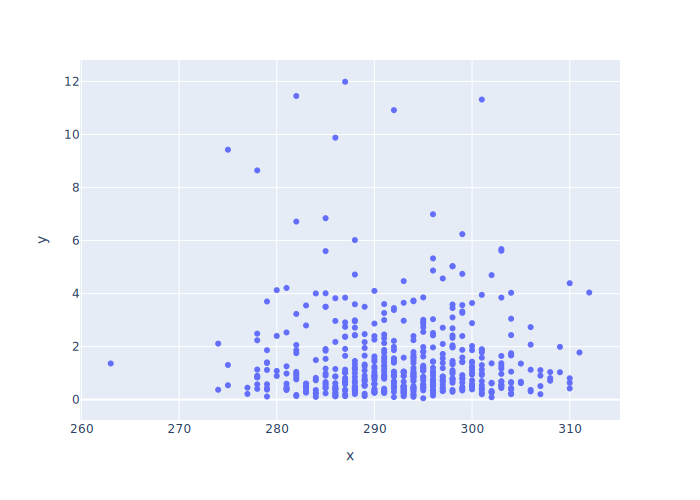

In [163]:
fig = px.scatter(
    x=combined_ordered_samples[:, 0],
    y=combined_ordered_samples[:, 1]
)
fig.show()

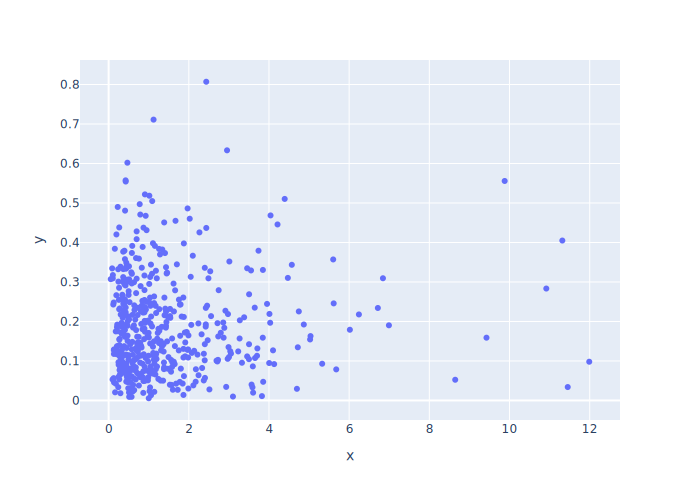

In [164]:
fig = px.scatter(
    x=combined_ordered_samples[:, 1],
    y=combined_ordered_samples[:, 2]
)
fig.show()

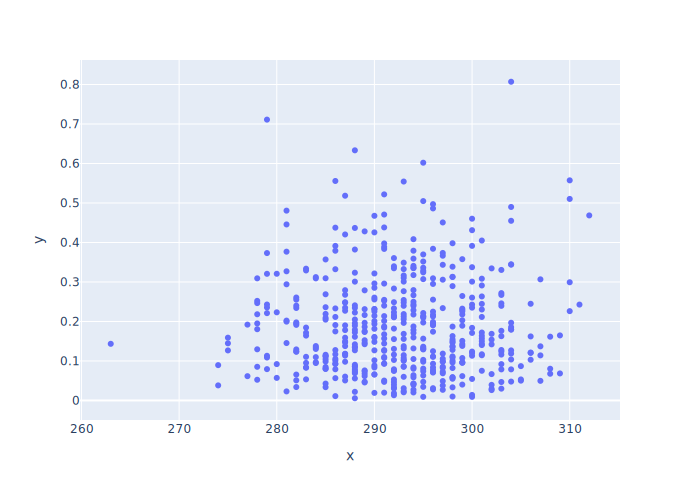

In [165]:
fig = px.scatter(
    x=combined_ordered_samples[:, 0],
    y=combined_ordered_samples[:, 2]
)
fig.show()